In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')

import seaborn as sns
import numpy as np

from sklearn import set_config ## SE AGREGA ESTO PARA QUE EL DIAGRAMA DEL PIPELINE APAREZCA INTERACTIVO
set_config(display='diagram') ## SE AGREGA ESTO PARA QUE EL DIAGRAMA DEL PIPELINE APAREZCA INTERACTIVO

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings("ignore")


In [ ]:
! python --version

In [ ]:
train = pd.read_csv('Train.csv')

In [42]:
train.head(2)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A


In [ ]:
train.info()

## Limpieza y EDA

### a. Control de calidad de los datos.
En esta sección se realiza una revisión del tipo de variables y el número de datos faltantes en el data set de entrenamiento.

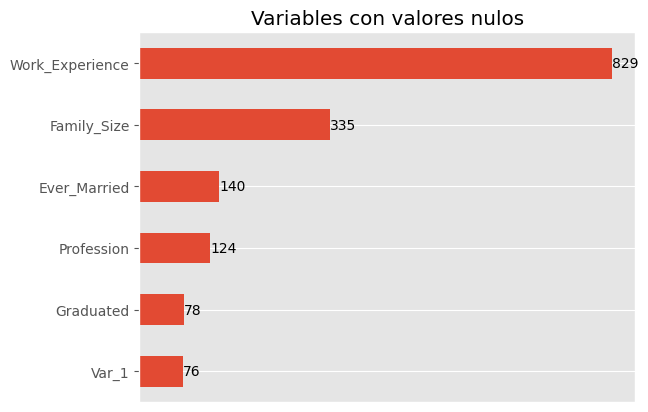

In [43]:
ax = train.isnull().sum()[train.isnull().sum()>0].sort_values().plot(kind = 'barh')
ax.bar_label(ax.containers[0])
ax.set_title('Variables con valores nulos')
ax.get_xaxis().set_visible(False)
plt.show()

In [44]:
train.isnull().sum(axis = 1).value_counts()

0    6665
1    1244
2     140
3      18
4       1
Name: count, dtype: int64

* En el control de calidad de los datos, se encuentra que el dataset consta de 8.608 observaciones y 11 variables, las cuales todas tienen el tipo de variable esperado. 

* Con respecto a los datos faltantes, la variable ***Work_Experience*** es la que mayor cantidad de nulos tiene (829), seguido de ***Family_Size*** (335).

* En cuanto a el número de nulos por observación se encuentra que, existen 6.665 registros completos, 1.244 registros con un dato faltante en 1 columna, 140 registros con datos faltantes en 2 columnas y 19 registros con al menos 3 columnas sin dato.

In [49]:
## SE DEFINE FUNCIÓN PARA SEPARAR LAS VARIABLES CATEGÓRICAS, NUMÉRICAS Y LA DEPENDIENTE
def SepararNumCate(df : pd.DataFrame):
    '''Returns a triplet with column names (numerical, categorical, target)
    '''
    numerical = df.select_dtypes(include = 'number').columns.to_list()
    categorical = df.select_dtypes(exclude = 'number').columns.to_list()
    categorical.remove('Segmentation') ## REMOVES THE TARGET VARIABLE
    target = ['Segmentation']
    return numerical, categorical, target


num_idx, categ_idx, target_idx = SepararNumCate(train)

In [50]:
## Identificar los valores únicos de las variables categóricas
for i in train[categ_idx + target_idx].columns:
    print(f'Categorías de la variable "{i}" ',train[i].unique(),'\n')

Categorías de la variable "Gender"  ['Male' 'Female'] 

Categorías de la variable "Ever_Married"  ['No' 'Yes' nan] 

Categorías de la variable "Graduated"  ['No' 'Yes' nan] 

Categorías de la variable "Profession"  ['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing' nan] 

Categorías de la variable "Spending_Score"  ['Low' 'Average' 'High'] 

Categorías de la variable "Var_1"  ['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' nan 'Cat_5'] 

Categorías de la variable "Segmentation"  ['D' 'A' 'B' 'C'] 



Para elegir qué se va a realizar con respecto a los valores faltantes se proponen 3 estrategias que se pondrán a prueba:

> - 1. Un data set de entrenamiento eliminando todos las observaciones que tengan al menos 1 dato faltante, lo que representa quedarse con un 75% del data set de entrenamiento inicial.

> - 2. Un data set de entrenamiento donde se eliminan las observaciones que tienen 2 o más datos nulos y a la observación que quede con dato un nulo se le asigna el valor del dato, mediante algún método de imputación.

> - 3. Un data set donde no se elimina ningún registro, se asigna el valor de los datos por algún método de imputación.

Después de entrenados los modelos (imputers), se realizará la evaluación del desempeño de los modelos empleando un **pipeline** 
//TODO ...mejorar esta redacción del pipe line y los modelos

### Estrategia 1

No hay que hacer ningún tratamiento de imputación, sólo eliminar las filas que contengan NA's.

In [46]:
train1 = train.dropna( axis = 0).copy()

### Estrategia 2

In [47]:
train2 = train.drop(train.loc[train.isna().sum(axis = 1) >= 2].index).copy()

In [55]:
### Pipelines

numerical_pipeline = Pipeline( steps = [
    ('scaler',StandardScaler())
])

categ_pipeline = Pipeline( steps = [
    ('encoder',OneHotEncoder(handle_unknown = 'ignore'))
])

## ColumnTransformer
columnsTransf = ColumnTransformer(transformers = [
                    ('numerical_pl',numerical_pipeline,num_idx),
                    ('categorical_pl',categ_pipeline,categ_idx)
                            ],
                    remainder = 'drop'
                                )

rf_model = RandomForestClassifier(random_state = 123)
lr_model = LogisticRegression()
nb_model = GaussianNB()


### Diccionario que contiene todos los pipelines
pl_dict = { 'RandomForest' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',rf_model)
                                        ]),
            'LogisticRegression' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',lr_model)
                                        ]),
            'NaiveBayes' : Pipeline( steps = [
                                    ('col_transf',columnsTransf),
                                    ('model',nb_model)
                                         ])
           }

In [ ]:

def ImputersTest(df : pd.DataFrame,  numerical_columns : list, 
                 categorical_columns : list, target : str, model : str): 
    X_train, X_test, y_train, y_test = train_test_split(df[numerical_columns + categorical_columns], df[target], test_size = 0.2)
    pipe = pl_dict.get(model)
    pipe.fit(X_train,y_train)
    predictions = pipe.predict(X_test)

### Estrategia 3

In [48]:
train3 = train.copy()

#### Separar variables para imputar

In [ ]:
## SEPARAMOS LAS VARIABLES CATEGÓRICAS Y NUMÉRICAS
numerical_x = train[train.select_dtypes(include = 'number').columns].copy()
categorical_x = train[train.select_dtypes(exclude = 'number').columns].drop('Segmentation', axis = 1).copy()
y = train['Segmentation']

- SE DEBE:
    - ESTANDARIZAR LAS VARIABLES NUMÉRICAS
    - ONE HOT ENCODER CON LAS VARIABLES CATEGÓRICAS
    - UNIRLOS EN UN DATASET
        > - PROBAR DIFERENTES MÉTODOS DE IMPUTACIÓN, MEDIA, MEDIANA
        > - EVALUARLOS Y DEFINIR CON CUÁL MÉTODO SE QUEDA

    

In [ ]:
### SE ESTANDARIZAN LAS NUMÉRICAS Y SE HACE ONE HOT ENCODING CON LAS CATEGÓRICAS
numerical_std = pd.DataFrame(StandardScaler().fit_transform(numerical_x), columns = numerical_x.columns)
categorical_ohe = pd.get_dummies(categorical_x, dtype = np.int8)

### SE UNEN AMBOS TIPOS DE VARIABLES
x_1 = pd.concat([numerical_std, categorical_ohe], axis = 1)


####  - SimpleImputer

In [ ]:
scores_simpleImput = []

for i in ['mean', 'median','most_frequent']: #### REVISAR ESTO TAMBIÉN
    imputer = SimpleImputer(strategy = i)
    x_simpImp = pd.DataFrame(imputer.fit_transform(x_1), columns = x_1.columns)
    classifier = KNeighborsClassifier()
    classifier.fit(x_simpImp, train['Segmentation'])
    scores_simpleImput.append(cross_val_score(classifier,x_simpImp, train['Segmentation'], cv = 10, scoring = 'accuracy').mean())

plt.plot(['mean', 'median','most_frequent'],scores_simpleImput)
plt.title('Performance of different strategies on prediction')
plt.show()

#### - KNNImputer

In [ ]:
scores_KnnImp = []

for i in range(1,10):
    imputer = KNNImputer(n_neighbors = i)
    x_KnnImp = pd.DataFrame(imputer.fit_transform(x_1), columns = x_1.columns)
    classifier = KNeighborsClassifier()
    classifier.fit(x_KnnImp, train['Segmentation'])
    scores_KnnImp.append(cross_val_score(classifier,x_KnnImp, train['Segmentation'], cv = 10, scoring = 'accuracy').mean())

plt.plot(range(1,10),scores_KnnImp)
plt.title('Performance of different neighbors on prediction')
plt.show()

#### - Iterative Imputer

In [ ]:
scores_iterImp = []

for i in range(1,10):
    imputer = IterativeImputer(random_state = 123, n_nearest_features = i)
    x_iterImp = pd.DataFrame(imputer.fit_transform(x_1), columns = x_1.columns)
    classifier = KNeighborsClassifier()
    classifier.fit(x_iterImp, train['Segmentation'])
    scores_iterImp.append(cross_val_score(classifier,x_iterImp, train['Segmentation'], cv = 10, scoring = 'accuracy').mean())

plt.plot(range(1,10),scores_iterImp)
plt.title('Performance of different neighbors on prediction')
plt.show()

In [ ]:
###  CLASIFICACIÓN ES MAYOR, PUESTO QUE ES EL ACCURACY

scores_iterImp[np.argmax((scores_iterImp))] ### BEST SCORE OF ITERATIVE/MICE
scores_KnnImp[np.argmax((scores_KnnImp))] ### BEST SCORE OF KNN IMPUTER
scores_simpleImput[np.argmax((scores_simpleImput))] ### BEST SCORE OF SIMPLE IMPUTER

0.47657592836870927

In [ ]:
### EL MÉTODO QUE MEJOR RESULTADO ARROJÓ FUE EL KNEAREST NEIHGBORS IMPUTER CON 2 VECINOS

imputer = KNNImputer(n_neighbors = 2) ## arreglar
x_KnnImp = pd.DataFrame(imputer.fit_transform(x_1), columns = x_1.columns)

## Modelos predictivos

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_KnnImp, y, test_size = 0.2, random_state = 1)

In [ ]:
score_rf_clsf = []

for i in range(1,20,2):
    rf_clsf = RandomForestClassifier(max_depth = i)
    rf_clsf.fit(X_train,y_train)
    score_rf_clsf.append(cross_val_score(rf_clsf, X_train, y_train, scoring = 'accuracy', cv = 10).mean())

plt.plot(range(1,20,2),score_rf_clsf)
plt.title('Accuracy of prediction')
plt.show()

In [ ]:
score_knn_clsf = []

for i in range(1,100,2):
    knn_clsf = KNeighborsClassifier(n_neighbors = i)
    knn_clsf.fit(X_train,y_train)
    score_knn_clsf.append(cross_val_score(knn_clsf, X_train, y_train, scoring = 'accuracy', cv = 10).mean())

plt.plot(range(1,100,2),score_knn_clsf)
plt.title('Accuracy of prediction')
plt.show()

PROPUESTA
1. IMPUTACIÓN
2. DESCRIPTIVAS
3. MODELOS


### b. Visualización de la información

In [ ]:
## SE ELIMINA EL ID PUESTO QUE NO ES NECESARIO PARA EL ANÁLISIS
train.drop('ID', axis = 1, inplace = True)

* **Balanceo de la variable dependiente**

  Cada una de las categorías de la variable Segmentation contiene alrededor del 25% de las observaciones, por lo que al dataset no hay que realizarle procesos de balanceo.

In [ ]:
ax = train.Segmentation.value_counts(normalize = True).sort_index().plot( kind = 'bar')
ax.get_yaxis().set_visible(False)
labels = (train.Segmentation.value_counts(normalize = True).sort_index()*100).round(1).astype('str') + '%' ## ETIQUETA DE LAS BARRAS QUE SE MUESTRE EN %
ax.tick_params(axis='x', rotation = 0)  ## ROTAR LAS ETIQUETAS DEL EJE X
for container in ax.containers:
    ax.bar_label(container, labels = labels)
plt.show()

DESCRIPCIÓN VARIABLES NUMÉRICAS VS VARIABLE DEPENDIENTE
* **Segmentación vs Edad:**

    En los siguientes gráficos se observa que el grupo D, tiene en promedio una edad menor que el resto de grupos, siendo esta alrededor de los 32 años. Los 3 grupos restantes tienen una edad promedio muy cercana a los 50 años.

* **Segmentación vs Experiencia laboral**

    En la gráfica siguiente se observa que el promedio de experiencia laboral para todas las categorías de Segmentation se encuentra entre los 2 y 3 años, también es posible identificar que el grupo D es el que más experiencia tiene puesto que un 75% de los individuos tienen una experiencia laboral de 6 años o menos, y el grupo C es el que menos experiencia tiene ya que el 75% de los individuos tienen una experiencia de 3 años o menos.


* **Segmentation vs Family Size**

  El tamaño del núcleo familiar tiene una distribución similar para los segmentos B, C y D, donde el 75% de los individuos cada uno de estos grupos tiene un núcleo familiar conformado por 4 o menos personas, por otra parte el núcleo familiar del Segmento A es más reducido donde el 75% de los individuos tienen un núcleo familiar de 3 o menos personas.

In [ ]:
fig, (ax1 ,ax2, ax3) = plt.subplots(1,3, figsize = (14,4))
#sns.histplot(data = train, x  = 'Age', hue = 'Segmentation', kde = True, ax = ax1)
sns.boxplot(data = train, x = 'Segmentation', y = 'Age',order = train.Segmentation.sort_values().unique(), ax = ax1, showmeans = True, palette = 'vlag')
sns.boxplot(data = train, x = 'Segmentation', y = 'Work_Experience', order = train.Segmentation.sort_values().unique(), ax = ax2, showmeans = True,palette="vlag")
sns.boxplot(data = train, x = 'Segmentation', y = 'Family_Size', order = train.Segmentation.sort_values().unique(), ax = ax3, showmeans = True, palette="vlag")
# Calcular la media por categoría
means = train.groupby('Segmentation')[['Age', 'Work_Experience', 'Family_Size']].mean().values

# Agregar líneas para la media y la mediana
#for i in range(len(train.Segmentation.sort_values().unique())):
 #   plt.text(i, means[i], f'{means[i]:.2f}', ha='center', va='bottom', color='blue', fontsize=8)

# Mostrar el gráfico
plt.show()


* **Género vs Segmentación**

   Con respecto a la distribución del género por Segmentación, la participación en todos los grupos de ambos géneros es similar a excepción del grupo D, donde la participación de los hombres es casi del 60%.

* **Ever_Married vs Segmentación**
  
  La variable categórica que toma en cuenta si el individuo ha estado casado alguna vez presenta la siguiente distribución: en los grupos A, B y C la mayoría de personas han estado casados, teniendo una mayor participación elos grupos A y B alcanzando casi el 80%. El grupo D por el contrario más del 70% de los individuos no han estado casados, este grupo como se vió en anteriores gráficas es el grupo con menor promedio de edad.
  
* **Graduated vs Segmentation**

    La variable binaria que captura si el individuo se graduó sigue el comportamiento siguiente diferenciándola por la Segmentación: En los grupos A, B y C más del 60% son graduados, caso contrario en el grupo D donde poco más del 60% de los individuos no son graduados.

* **Spending_Score vs Segmentation**
    La variable categórica que captura si el puntaje de consumo es bajo, medio o alto presenta la siguiente distribución: Los grupos A, B y D predominan las personas que tienen un consumo bajo, siendo en el grupo D casi la totalidad de personas que tienen un consumo bajo, por su parte en el grupo C  predomina el consumo promedio con un poco más del 40%.

* **Profession vs Segmentation**
  
  Con respecto a la profesión del cliente:
    - El grupo A la mayor participación la tienen los artistas con casi el 30% de los individuos seguido de los profesionales del entretenimiento.
    - El grupo B la mayor participación la tienen los artistas con más del 40% de los individuos seguido por los profesionales del entretenimiento.
    - El grupo C la mayor participación la tienen los artistas con más del 50% de los individuos seguido por los ejecutivos.
    - El grupo D la mayor participación la tienen los profesionales de la salud con más del 40% seguido por los doctores y profesionales del entretenamiento.
     
* **Var_1 vs Segmentation**

  Con respecto a una categoría anónima que se le asigna a cada cliente la categoría 6 tiene la mayor participación en todos los segmentos con más del 60% de todos los individuos para los grupos A, B y C, y más del 50% en el grupo D

In [ ]:
fig, ((ax1, ax2),
      (ax3, ax4),
      (ax5, ax6)) = plt.subplots(3,2, figsize = (18,12), sharey = True)
pd.crosstab(train.Segmentation,train.Gender,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax1, edgecolor = 'black',colormap= 'vlag')
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax1.tick_params(axis='x', rotation=0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax1.legend(loc = 'upper left', title = 'Gender')
ax1.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Ever_Married,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax2, edgecolor = 'black', colormap= 'vlag')
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax2.tick_params(axis='x', rotation=0) 
ax2.legend(loc = 'upper left')
ax2.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Graduated,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax3, edgecolor = 'black',colormap= 'vlag')
ax3.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax3.tick_params(axis='x', rotation=0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax3.legend(loc = 'upper left', title = 'Graduated')
ax3.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Spending_Score,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax4, edgecolor = 'black',colormap= 'vlag')
ax4.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax4.tick_params(axis='x', rotation = 0) 
ax4.legend(loc = 'upper left')
ax4.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Profession,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax5, edgecolor = 'black',colormap= 'vlag')
ax5.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax5.tick_params(axis='x', rotation=0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax5.legend(loc = 'upper left', ncols = 3)
ax5.set_xlabel(None)

pd.crosstab(train.Segmentation,train.Var_1,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax6, edgecolor = 'black',colormap= 'vlag')
ax6.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax6.tick_params(axis='x', rotation=0) 
ax6.legend(loc = 'upper left', ncols = 3)
ax6.set_xlabel(None)
fig.suptitle('Variables categóricas vs variable objetivo', fontsize = 20)
plt.show()

In [ ]:
def calcular_coeficiente_contingencia(df: pd.DataFrame, cols: list, target_col: str) -> pd.DataFrame:
    resultados = []
    for col in cols:
        tabla_contingencia = pd.crosstab(df[col], df[target_col])
        chi2, p, dof, expected = chi2_contingency(tabla_contingencia)
        n = tabla_contingencia.values.sum()
        coef_contingencia = np.sqrt(chi2 / (n * min(len(tabla_contingencia.index) - 1, len(tabla_contingencia.columns) - 1)))
        resultados.append([col, coef_contingencia])
    df_resultado = pd.DataFrame(resultados, columns=['Variable', 'Coeficiente de Contingencia'])
    df_resultado.sort_values(by='Coeficiente de Contingencia', ascending=False, inplace=True)
    df_resultado.reset_index(drop=True, inplace=True)
    return df_resultado.round(4)

In [ ]:
calcular_coeficiente_contingencia(train1,categ_idx, 'Segmentation')

**Interpretación asociación entre variables categóricas independientes y variabel objetivo**
 - Todas las variables tienen un coeficiente menor a 0.6, por lo que ninguna presenta una asociación relativamente intensa con la variable objetivo. Sin embargo, la variable Ever_Married es la que mayor coeficiente de asociación tiene.


### c. Extracción de información de los datos

### d. Comprensión y limpieza de datos


**Pipelines**

In [ ]:
## Pipeline sin nulos

numerical_pipeline = Pipeline( steps = [
    ('scaler',StandardScaler())
])

categ_pipeline = Pipeline( steps = [
    ('encoder',OneHotEncoder(handle_unknown = 'ignore'))
])

## ColumnTransformer
columnsTransf = ColumnTransformer(transformers = [
                    ('numerical_pl',numerical_pipeline,num_idx),
                    ('categorical_pl',categ_pipeline,categ_idx)
                            ],
                    remainder = 'drop'
                                )
rf_model = RandomForestClassifier(random_state = 123)

rf_pipeline = Pipeline( steps = [
    ('col_transf',columnsTransf),
    ('model',rf_model)
])

In [ ]:
## MOSTRAR EL PIPELINE
rf_pipeline

In [ ]:
## DIVIDIR EL DATASET
X_train, X_test, y_train, y_test = train_test_split(train1[num_idx + categ_idx], train1[target_idx], test_size = 0.2)

In [ ]:
## ENTRENAR EL MODELO
rf_pipeline.fit(X_train, y_train)

In [ ]:
## OBTENER PREDICCIONES
predictions = rf_pipeline.predict(X_test)

In [ ]:
rf_pipeline.score(X_test, y_test)

## Reducción dimensionalidad

## Caracterización de los clientes por segmento